# Analytics Raw: Visualização de Dados Brutos

## 1. Introdução
Este notebook carrega os arquivos CSV segmentados (`imoveis_padrao.csv` e `imoveis_luxo.csv`) da camada Raw. O objetivo é realizar a análise exploratória inicial (EDA) para identificar sujeira, outliers e inconsistências antes do tratamento ETL, comparando o comportamento entre o mercado de massa e o de alto padrão. Diferente da camada Silver, aqui tratamos os dados como "suspeitos".

### 1.1 Configuração do ambiente e Carregamento (Python/Pandas)

**Objetivo:**
Preparar as bibliotecas visuais, localizar os arquivos segmentados e carregar os datasets para a memória, realizando conversões de tipo "on-the-fly" apenas para permitir a geração de gráficos.

**Ações:**
* Aplica tema gráfico `whitegrid` (Clean Profissional) e define dimensões padrão.
* Define função `format_currency` para eixos em Dólar ($).
* Implementa busca inteligente dos arquivos `imoveis_padrao.csv` e `imoveis_luxo.csv` em múltiplos diretórios (local/Docker).
* Carrega dados inicialmente como texto (`dtype=str`) para preservação total.
* Gera DataFrames independentes (`df_padrao` e `df_luxo`) convertendo colunas numéricas (`price`, `bed`, `bath`, etc.) e padronizando nomes de cidades para visualização.

**Saída:**
* Caminhos dos arquivos encontrados.
* Confirmação de carregamento ("Tudo pronto para os gráficos comparativos").
* Total de registros carregados para cada segmento (Memória Padrão vs Luxo).

**Observação:**
* Unidades monetárias em Dólar ($), pois estamos na camada Raw (nomes originais em inglês).
* Erros de conversão numérica são transformados em `NaN` (Not a Number) para serem quantificados nos gráficos de qualidade de dados.

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.ticker import FuncFormatter

# --- 1. SETUP VISUAL ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 8) # Largura extra para comparação lado a lado
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

def format_currency(x, pos):
    if x >= 1e6: return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}k'.format(x*1e-3)

# --- 2. CARREGAMENTO DOS ARQUIVOS DIVIDIDOS ---
# Como você já rodou o script split_raw_data.py, vamos carregar direto os arquivos processados.

def carregar_arquivo(nome_arquivo):
    possible_paths = [
        nome_arquivo,
        os.path.join('Data Layer', 'raw', nome_arquivo),
        os.path.join('raw', nome_arquivo),
        os.path.join('..', 'Data Layer', 'raw', nome_arquivo),
        # Se estiver na mesma pasta que o notebook:
        os.path.join('.', nome_arquivo) 
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ Carregando: {path}...")
            # Carrega como string primeiro para não perder formatos, depois converte
            df = pd.read_csv(path, dtype=str)
            return df
    
    print(f"❌ ARQUIVO NÃO ENCONTRADO: {nome_arquivo}")
    return None

# Carrega os dois datasets separadamente
df_padrao_raw = carregar_arquivo('imoveis_padrao.csv')
df_luxo_raw = carregar_arquivo('imoveis_luxo.csv')

if df_padrao_raw is None or df_luxo_raw is None:
    raise FileNotFoundError("Rode o script 'split_raw_data.py' primeiro para gerar os CSVs!")

# --- 3. CONVERSÃO DE TIPOS (Para permitir gráficos) ---
cols_num = ['price', 'bed', 'bath', 'house_size', 'acre_lot']

def preparar_dataframe(df_in):
    df_out = df_in.copy()
    for c in cols_num:
        if c in df_out.columns:
            df_out[c] = pd.to_numeric(df_out[c], errors='coerce')
    
    if 'city' in df_out.columns:
        df_out['city'] = df_out['city'].astype(str).str.title().str.strip()
    
    return df_out

# Aplica a conversão
df_padrao = preparar_dataframe(df_padrao_raw)
df_luxo = preparar_dataframe(df_luxo_raw)

print("-" * 50)
print(f"📉 Mercado Padrão (Memória): {len(df_padrao)} registros")
print(f"📈 Mercado de Luxo (Memória):   {len(df_luxo)} registros")
print("-" * 50)
print("🚀 Tudo pronto para os gráficos comparativos!")

✅ Carregando: imoveis_padrao.csv...
✅ Carregando: imoveis_luxo.csv...
--------------------------------------------------
📉 Mercado Padrão (Memória): 2031154 registros
📈 Mercado de Luxo (Memória):   193687 registros
--------------------------------------------------
🚀 Tudo pronto para os gráficos comparativos!


### 1.Top 15 Cidades com Mais Anúncios
* **Objetivo:** Identificar se há concentração excessiva de dados em uma única cidade (possível erro de raspagem) ou se a distribuição geográfica faz sentido.
* **O que procurar (Outliers):** Cidades com grafia errada aparecendo no topo (ex: "New York" vs "New  York") ou cidades minúsculas com milhares de anúncios duplicados.

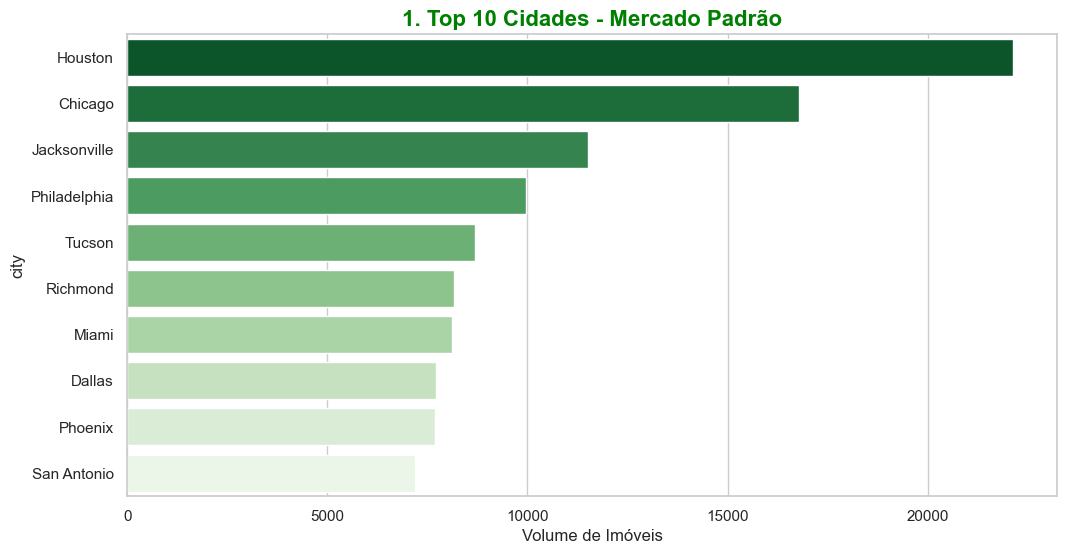

In [78]:
# --- GRÁFICO 1: Top Cidades (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 6))

# Nota: No Raw usamos 'city' (em inglês)
top_cities_p = df_padrao['city'].value_counts().head(10)

_ = sns.barplot(
    x=top_cities_p.values, 
    y=top_cities_p.index, 
    hue=top_cities_p.index, # Define a cor pela cidade
    palette='Greens_r', 
    legend=False            # Remove a legenda
)

plt.title('1. Top 10 Cidades - Mercado Padrão', fontweight='bold', color='green')
plt.xlabel('Volume de Imóveis')
plt.show()

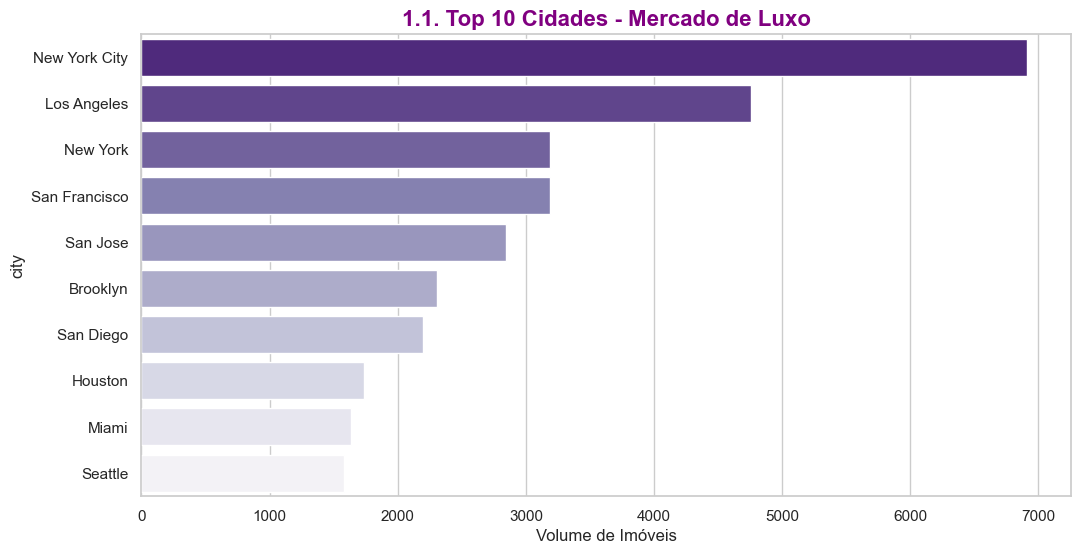

In [79]:
# --- GRÁFICO 1.1: Top Cidades (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 6))

top_cities_l = df_luxo['city'].value_counts().head(10)

_ = sns.barplot(
    x=top_cities_l.values, 
    y=top_cities_l.index, 
    hue=top_cities_l.index,
    palette='Purples_r', 
    legend=False
)

plt.title('1.1. Top 10 Cidades - Mercado de Luxo', fontweight='bold', color='purple')
plt.xlabel('Volume de Imóveis')
plt.show()

### 2. Distribuição de preços
* **Objetivo:** Detectar os erros grotescos de digitação financeira.
* **O que procurar (Outliers):** Pontos isolados na esquerda extrema (casas de $1, $10) e na direita extrema (imóveis de $100M+ em bairros simples). A "caixa" do gráfico mostra onde está o mercado real.

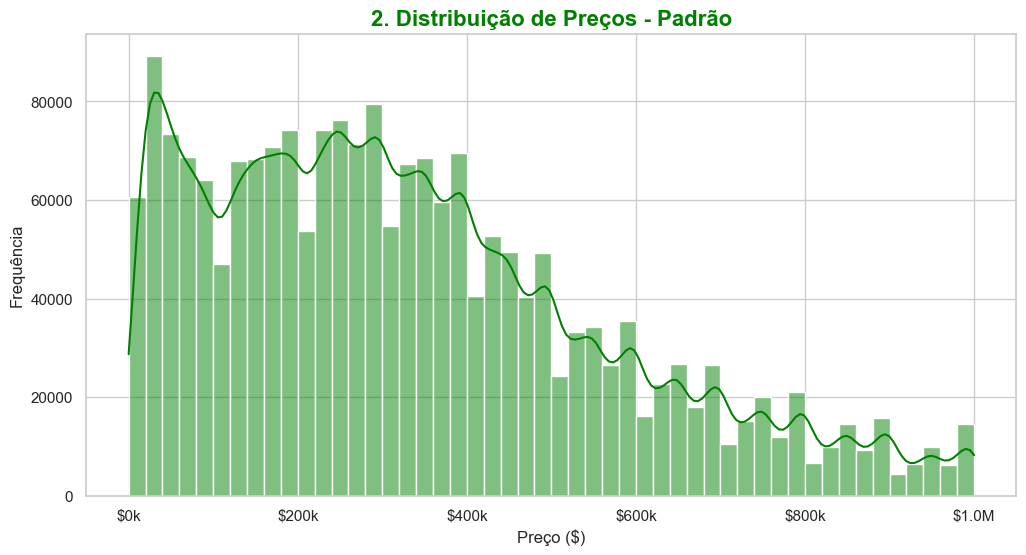

In [80]:
# --- GRÁFICO 2: Distribuição de Preços (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 6))

sns.histplot(data=df_padrao, x='price', kde=True, color='green', bins=50)
plt.title('2. Distribuição de Preços - Padrão', fontweight='bold', color='green')
plt.xlabel('Preço ($)')
plt.ylabel('Frequência')

# Formata o eixo X para ficar legível (ex: $500k)
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.show()

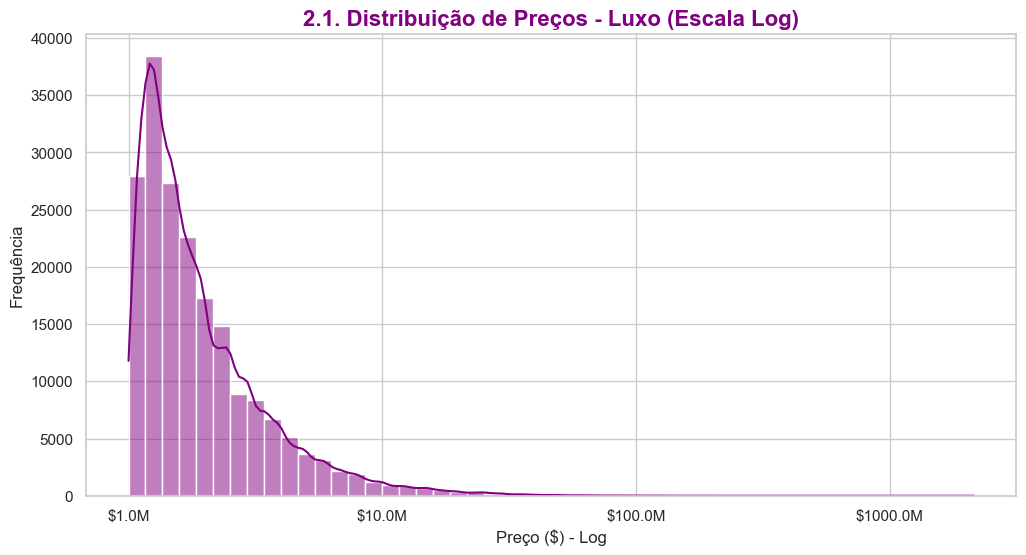

In [81]:
# --- GRÁFICO 2.1: Distribuição de Preços (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 6))

# Nota: Usamos log_scale no luxo porque a diferença entre $1M e $100M é gigante
sns.histplot(data=df_luxo, x='price', kde=True, color='purple', bins=50, log_scale=True)
plt.title('2.1. Distribuição de Preços - Luxo (Escala Log)', fontweight='bold', color='purple')
plt.xlabel('Preço ($) - Log')
plt.ylabel('Frequência')

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(format_currency))
plt.show()

### 3. Tamanho x Preço
* **Objetivo:** A "Batalha de Titãs" dos dados. Cruzamos as duas variáveis mais importantes para ver se a lógica "maior é mais caro" se sustenta.
* **O que procurar (Outliers):** * **Linhas Retas:** Imóveis com tamanhos variados mas exatamente o mesmo preço (dados sintéticos?).
    * **Formigas Gigantes:** Imóveis minúsculos (10 sqft) custando milhões.

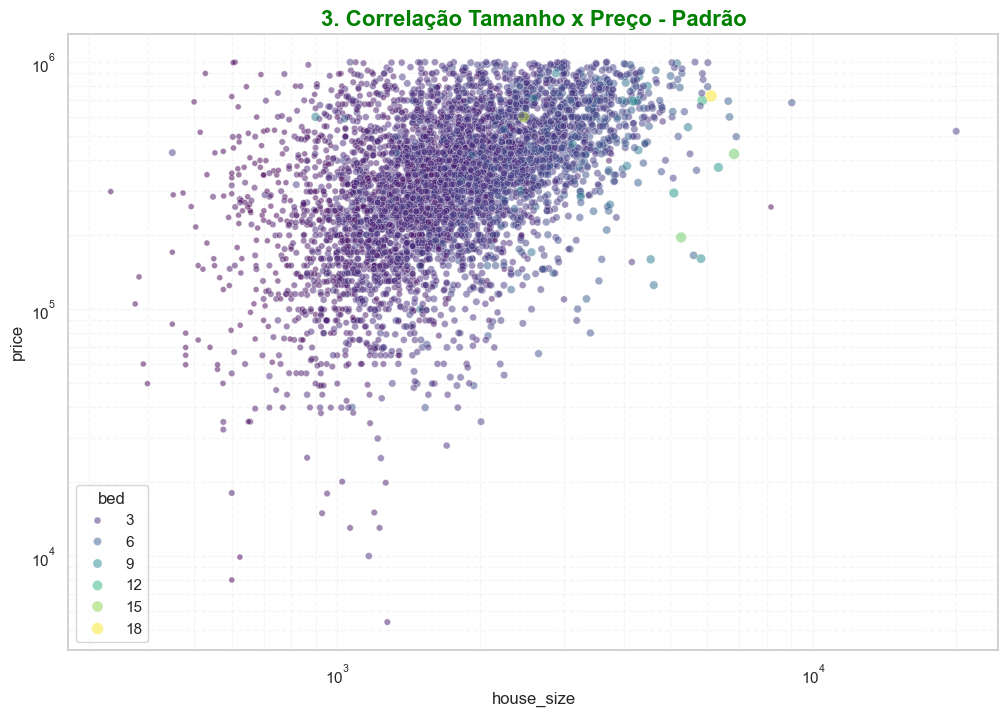

In [82]:
# --- GRÁFICO 3: Tamanho x Preço (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 8))

# Amostra para não travar o gráfico
subset_p = df_padrao[(df_padrao['house_size'] > 10) & (df_padrao['price'] > 1000)].sample(min(5000, len(df_padrao)))

sns.scatterplot(data=subset_p, x='house_size', y='price', hue='bed', palette='viridis', alpha=0.5, size='bed')
plt.xscale('log')
plt.yscale('log')
plt.title('3. Correlação Tamanho x Preço - Padrão', fontweight='bold', color='green')
plt.grid(True, which="both", ls="--", alpha=0.2)
plt.show()

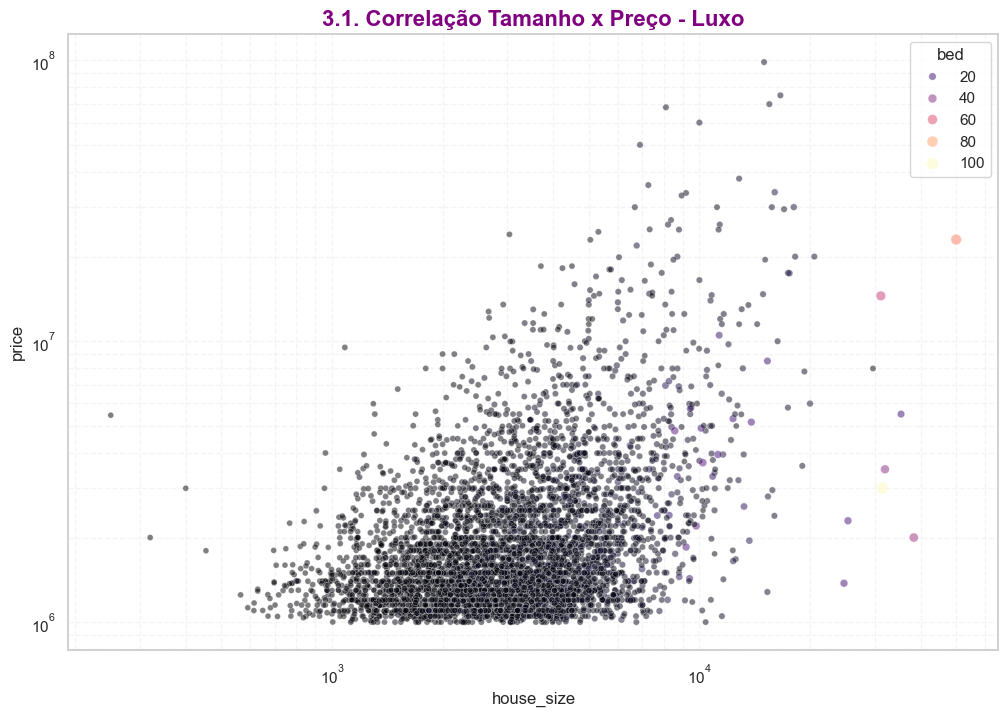

In [83]:
# --- GRÁFICO 3.1: Tamanho x Preço (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 8))

subset_l = df_luxo[df_luxo['house_size'] > 10].sample(min(5000, len(df_luxo)))

sns.scatterplot(data=subset_l, x='house_size', y='price', hue='bed', palette='magma', alpha=0.5, size='bed')
plt.xscale('log')
plt.yscale('log')
plt.title('3.1. Correlação Tamanho x Preço - Luxo', fontweight='bold', color='purple')
plt.grid(True, which="both", ls="--", alpha=0.2)
plt.show()

### 4. Média de Preço por Estado
* **Objetivo:** Comparar o "Desempenho" de valorização entre diferentes regiões.
* **O que procurar (Outliers):** Estados rurais aparecendo no topo do ranking acima de centros financeiros (NY, CA), indicando que os dados desse estado podem estar sujos ou com moeda errada.

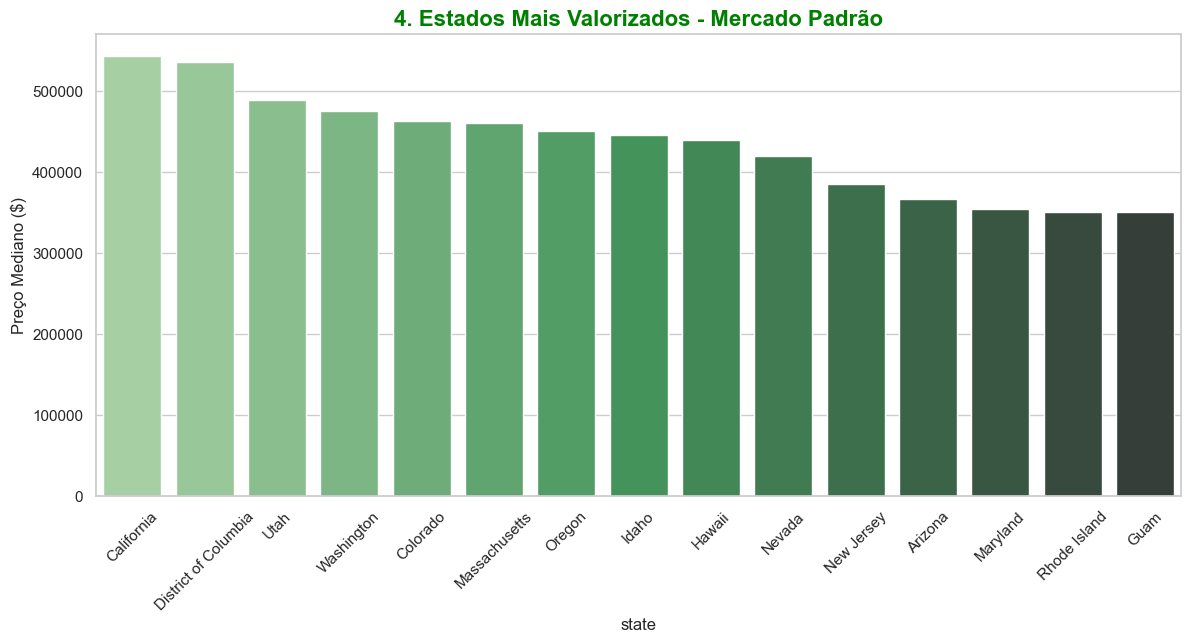

In [84]:
# --- GRÁFICO 4: Preço por Estado (MERCADO PADRÃO) ---
if 'state' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    state_price_p = df_padrao.groupby('state')['price'].median().sort_values(ascending=False).head(15)
    
    # CORREÇÃO: hue=state_price_p.index e legend=False
    _ = sns.barplot(
        x=state_price_p.index, 
        y=state_price_p.values, 
        hue=state_price_p.index, # Cor baseada no Estado
        palette='Greens_d', 
        legend=False
    )
    
    plt.title('4. Estados Mais Valorizados - Mercado Padrão', fontweight='bold', color='green')
    plt.xticks(rotation=45)
    plt.ylabel('Preço Mediano ($)')
    plt.show()

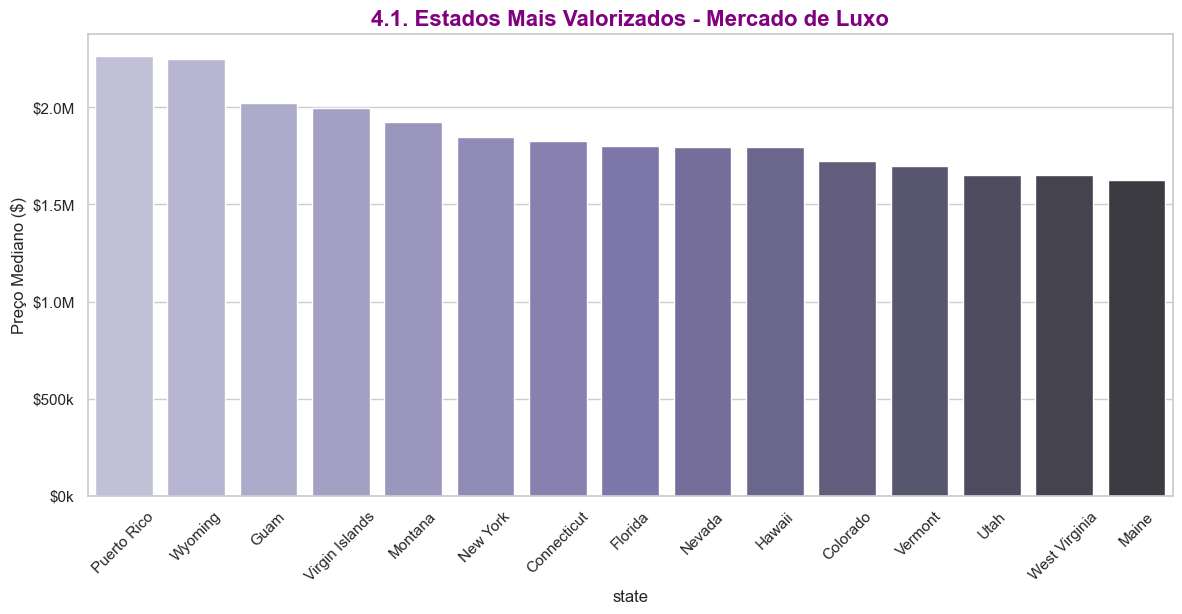

In [85]:
# --- GRÁFICO 4.1: Preço por Estado (MERCADO DE LUXO) ---
if 'state' in df_luxo.columns:
    plt.figure(figsize=(14, 6))
    state_price_l = df_luxo.groupby('state')['price'].median().sort_values(ascending=False).head(15)
    
    _ = sns.barplot(
        x=state_price_l.index, 
        y=state_price_l.values, 
        hue=state_price_l.index, # Cor baseada no Estado
        palette='Purples_d', 
        legend=False
    )
    
    plt.title('4.1. Estados Mais Valorizados - Mercado de Luxo', fontweight='bold', color='purple')
    plt.xticks(rotation=45)
    plt.ylabel('Preço Mediano ($)')
    
    # Formata eixo Y para Dólar (milhões/milhares)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.show()

### 5. A Lógica dos Quartos
* **Objetivo:** Verificar a consistência física dos imóveis.
* **O que procurar (Outliers):** * A barra do **0**: sem quarto.

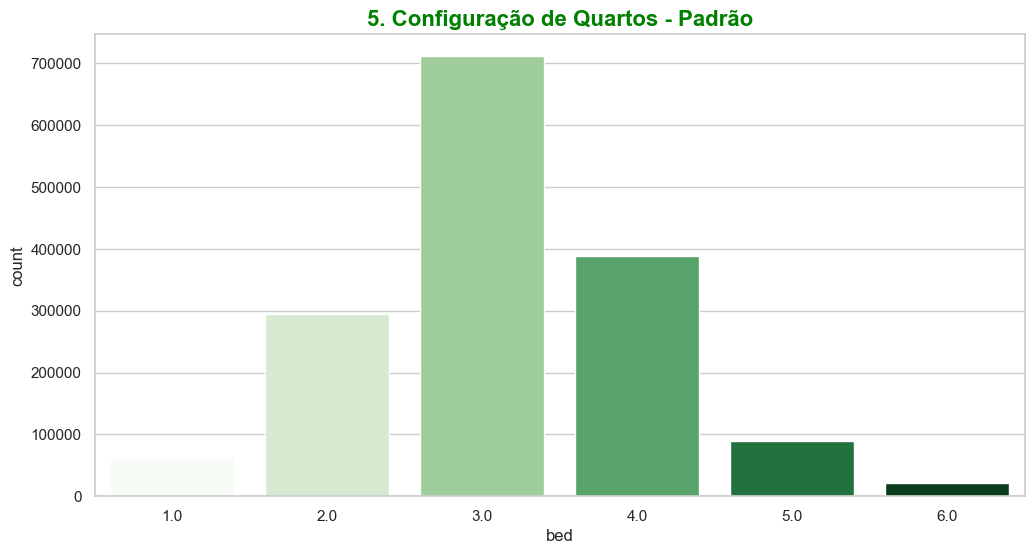

In [86]:
# --- GRÁFICO 5: Quartos (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 6))

# Filtra casas normais (1 a 6 quartos) para o gráfico não ficar poluição
df_quarto_p = df_padrao[df_padrao['bed'].between(1, 6)]

_ = sns.countplot(
    x='bed', 
    data=df_quarto_p, 
    hue='bed',        # Define a cor baseada no número de quartos
    palette='Greens', 
    legend=False      # Remove a legenda repetitiva
)

plt.title('5. Configuração de Quartos - Padrão', fontweight='bold', color='green')
plt.show()

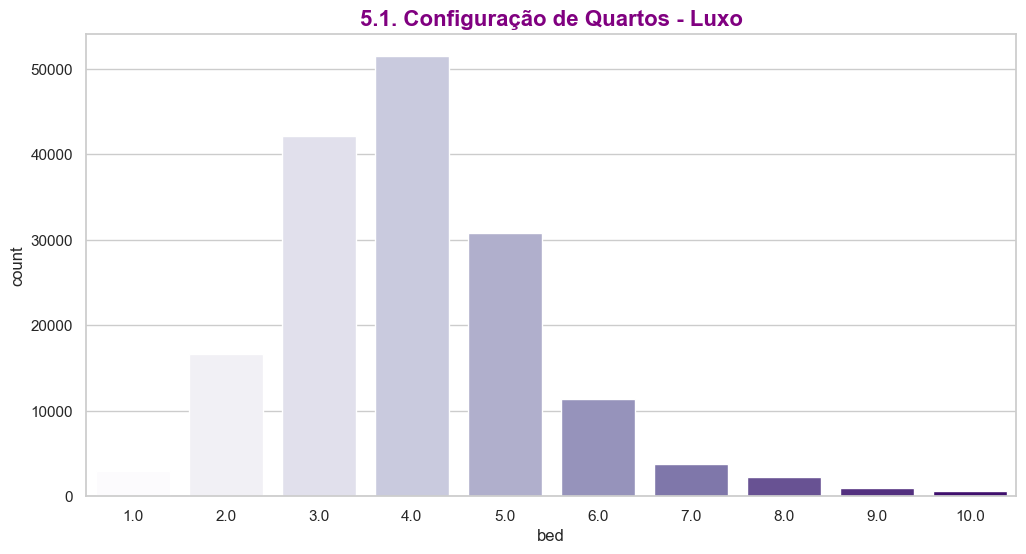

In [87]:
# --- GRÁFICO 5.1: Quartos (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 6))

# Filtra mansões de 1 até 10 quartos
df_quarto_l = df_luxo[df_luxo['bed'].between(1, 10)]

_ = sns.countplot(
    x='bed', 
    data=df_quarto_l, 
    hue='bed',        # Define a cor baseada no número de quartos
    palette='Purples', 
    legend=False      # Remove a legenda
)

plt.title('5.1. Configuração de Quartos - Luxo', fontweight='bold', color='purple')
plt.show()

### 6. Impacto do Lote no Preço
* **Objetivo:** Entender se ter terreno (`acre_lot` > 0) muda o patamar de preço.
* **O que procurar (Outliers):** Imóveis com terrenos gigantescos (milhares de acres) custando muito pouco (provavelmente erro de unidade, talvez sqft inserido como acre).

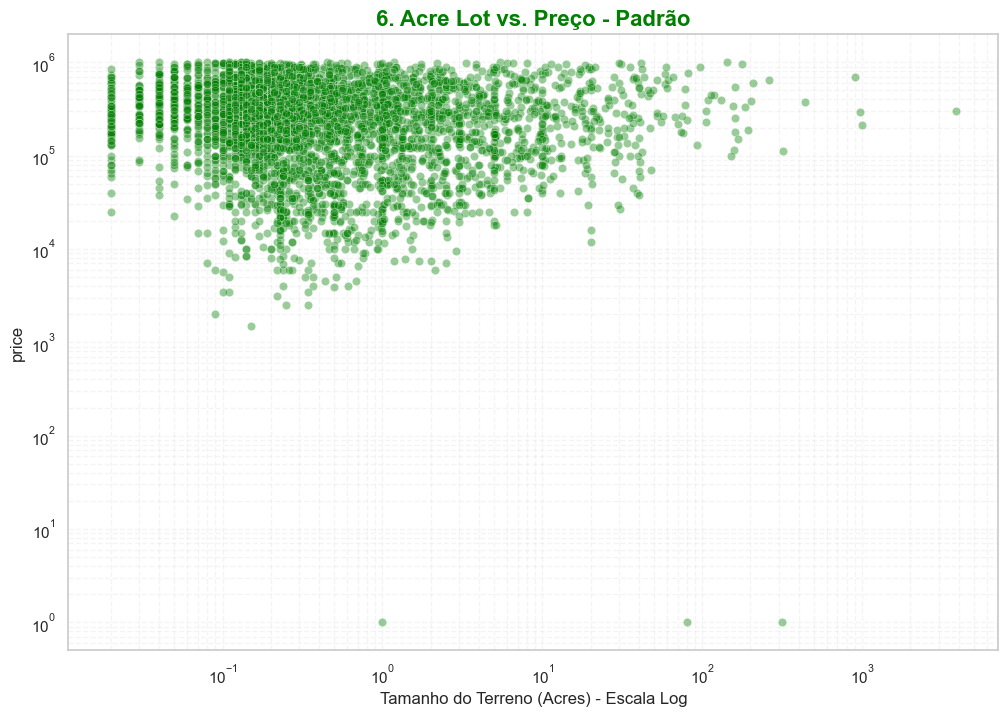

In [88]:
# --- GRÁFICO 6: Terreno vs. Preço (MERCADO PADRÃO) ---
if 'acre_lot' in df_padrao.columns:
    plt.figure(figsize=(12, 8))
    # Filtramos zeros para o log funcionar e pegamos uma amostra para não travar
    subset_lot_p = df_padrao[df_padrao['acre_lot'] > 0.01].sample(min(5000, len(df_padrao)))
    
    sns.scatterplot(data=subset_lot_p, x='acre_lot', y='price', color='green', alpha=0.4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('6. Acre Lot vs. Preço - Padrão', fontweight='bold', color='green')
    plt.xlabel('Tamanho do Terreno (Acres) - Escala Log')
    plt.grid(True, which="both", ls="--", alpha=0.2)
    plt.show()

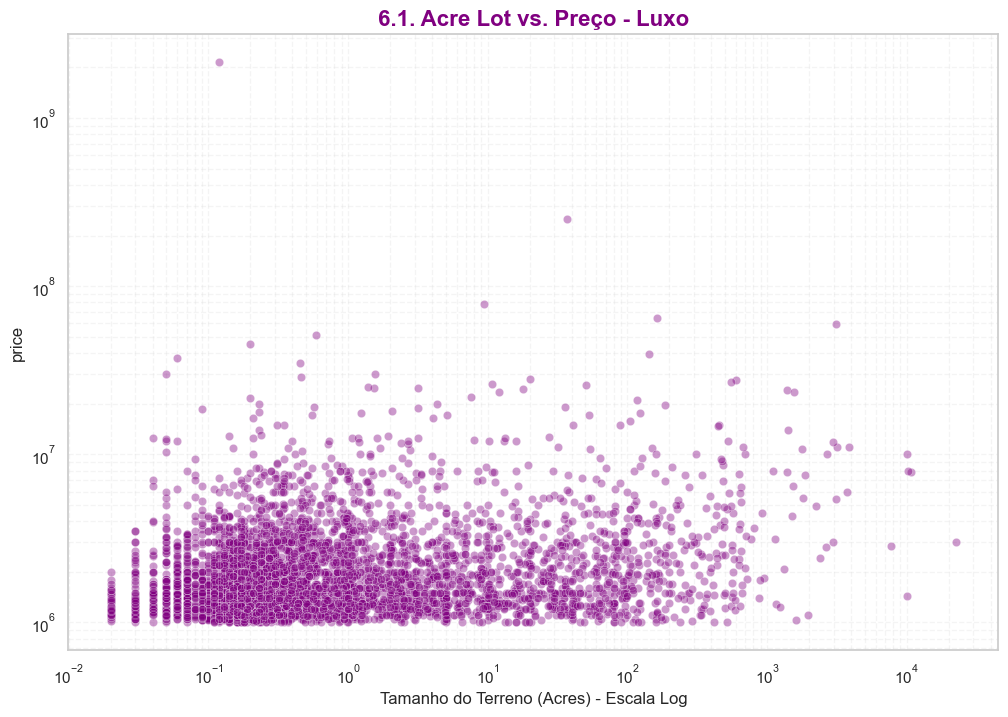

In [89]:
# --- GRÁFICO 6.1: Terreno vs. Preço (MERCADO DE LUXO) ---
if 'acre_lot' in df_luxo.columns:
    plt.figure(figsize=(12, 8))
    subset_lot_l = df_luxo[df_luxo['acre_lot'] > 0.01].sample(min(5000, len(df_luxo)))
    
    sns.scatterplot(data=subset_lot_l, x='acre_lot', y='price', color='purple', alpha=0.4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('6.1. Acre Lot vs. Preço - Luxo', fontweight='bold', color='purple')
    plt.xlabel('Tamanho do Terreno (Acres) - Escala Log')
    plt.grid(True, which="both", ls="--", alpha=0.2)
    plt.show()

### 7. Histórico e Volatilidade de Preço
* **Objetivo:** Analisar o comportamento de preço do endereço mais frequente da base (seja um condomínio com várias unidades à venda ou um imóvel revendido várias vezes).


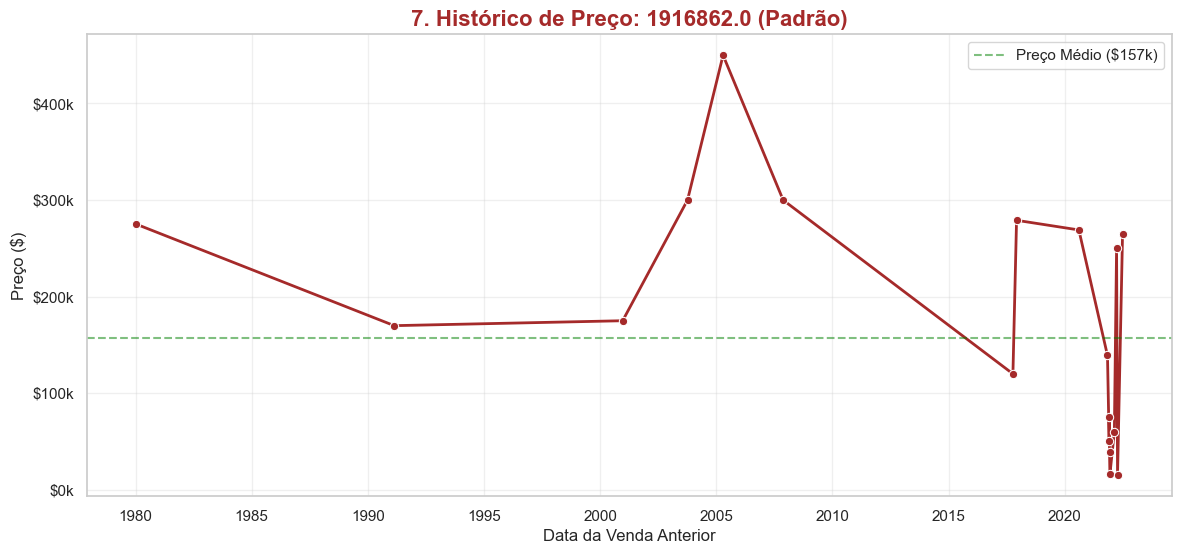

In [90]:
# --- GRÁFICO 7: Variância de Preço (MERCADO PADRÃO) ---
if 'street' in df_padrao.columns and 'price' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    
    # 1. Pega a rua/imóvel que mais se repete
    top_street_p = df_padrao['street'].value_counts().idxmax()
    
    # 2. Filtra e limpa
    df_top_p = df_padrao[df_padrao['street'] == top_street_p].copy()
    df_top_p = df_top_p.dropna(subset=['price']) # Garante que tem preço
    
    # 3. Define o Eixo X (Tempo ou Sequência)
    if 'prev_sold_date' in df_top_p.columns:
        # Tenta usar data real
        df_top_p['tempo'] = pd.to_datetime(df_top_p['prev_sold_date'], errors='coerce')
        # Se a conversão falhar (gerar NaT), usamos o índice original como tempo
        if df_top_p['tempo'].isnull().all():
             df_top_p['tempo'] = range(len(df_top_p))
             label_x = 'Sequência de Registros (Ordem de Coleta)'
        else:
             df_top_p = df_top_p.sort_values('tempo')
             label_x = 'Data da Venda Anterior'
    else:
        # Fallback: Usa a ordem das linhas
        df_top_p['tempo'] = range(len(df_top_p))
        label_x = 'Sequência de Registros'

    # 4. Plotagem (Linha + Pontos)
    sns.lineplot(data=df_top_p, x='tempo', y='price', marker='o', color='brown', linewidth=2)
    
    # Adiciona linha de média para referência
    media = df_top_p['price'].mean()
    plt.axhline(media, color='green', linestyle='--', alpha=0.5, label=f'Preço Médio ({format_currency(media, None)})')
    
    plt.title(f'7. Histórico de Preço: {top_street_p} (Padrão)', fontweight='bold', color='brown')
    plt.xlabel(label_x)
    plt.ylabel('Preço ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Formata eixo Y
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.show()

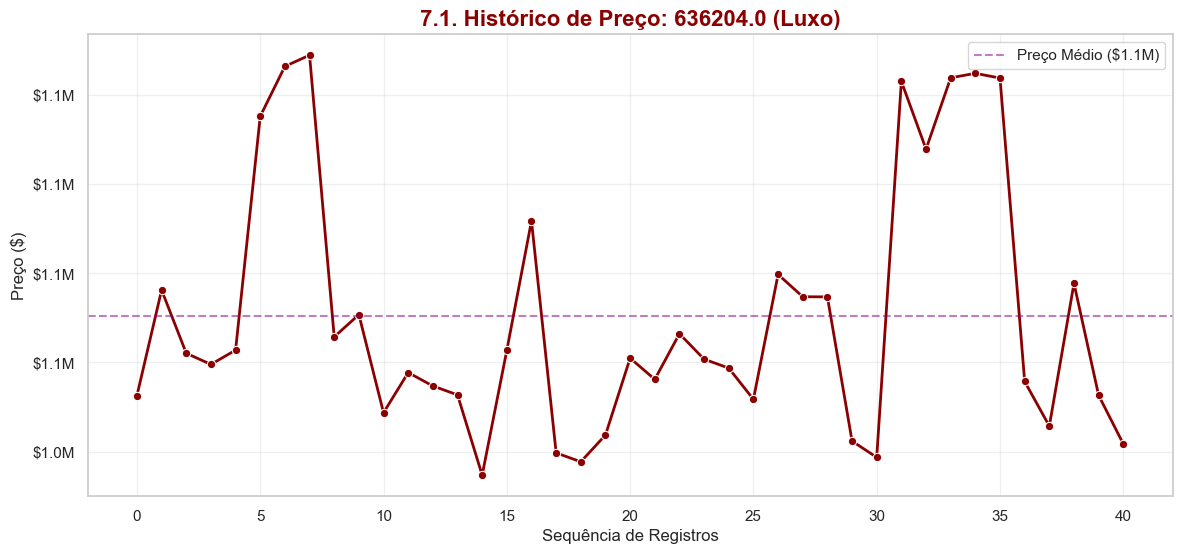

In [91]:
# --- GRÁFICO 7.1: Variância de Preço (MERCADO DE LUXO) ---
if 'street' in df_luxo.columns and 'price' in df_luxo.columns:
    plt.figure(figsize=(14, 6))
    
    top_street_l = df_luxo['street'].value_counts().idxmax()
    
    df_top_l = df_luxo[df_luxo['street'] == top_street_l].copy()
    df_top_l = df_top_l.dropna(subset=['price'])
    
    # Lógica de Tempo Blindada
    if 'prev_sold_date' in df_top_l.columns:
        df_top_l['tempo'] = pd.to_datetime(df_top_l['prev_sold_date'], errors='coerce')
        if df_top_l['tempo'].isnull().all():
             df_top_l['tempo'] = range(len(df_top_l))
             label_x = 'Sequência de Registros'
        else:
             df_top_l = df_top_l.sort_values('tempo')
             label_x = 'Data da Venda Anterior'
    else:
        df_top_l['tempo'] = range(len(df_top_l))
        label_x = 'Sequência de Registros'

    sns.lineplot(data=df_top_l, x='tempo', y='price', marker='o', color='darkred', linewidth=2)
    
    media_l = df_top_l['price'].mean()
    plt.axhline(media_l, color='purple', linestyle='--', alpha=0.5, label=f'Preço Médio ({format_currency(media_l, None)})')
    
    plt.title(f'7.1. Histórico de Preço: {top_street_l} (Luxo)', fontweight='bold', color='darkred')
    plt.xlabel(label_x)
    plt.ylabel('Preço ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.show()

### 8. O Preço por Pé Quadrado
* **Objetivo:** Criar uma métrica derivada (`Price / House Size`) para achar anomalias invisíveis. Uma casa pode ter preço normal e tamanho normal, mas se custa $1 milhão e tem 10m², o preço/m² é insano.
* **O que procurar (Outliers):** A cauda longa à direita. Imóveis com custo/sqft astronômico geralmente são erros de digitação no tamanho (esqueceram um zero).

c:\Users\julii\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


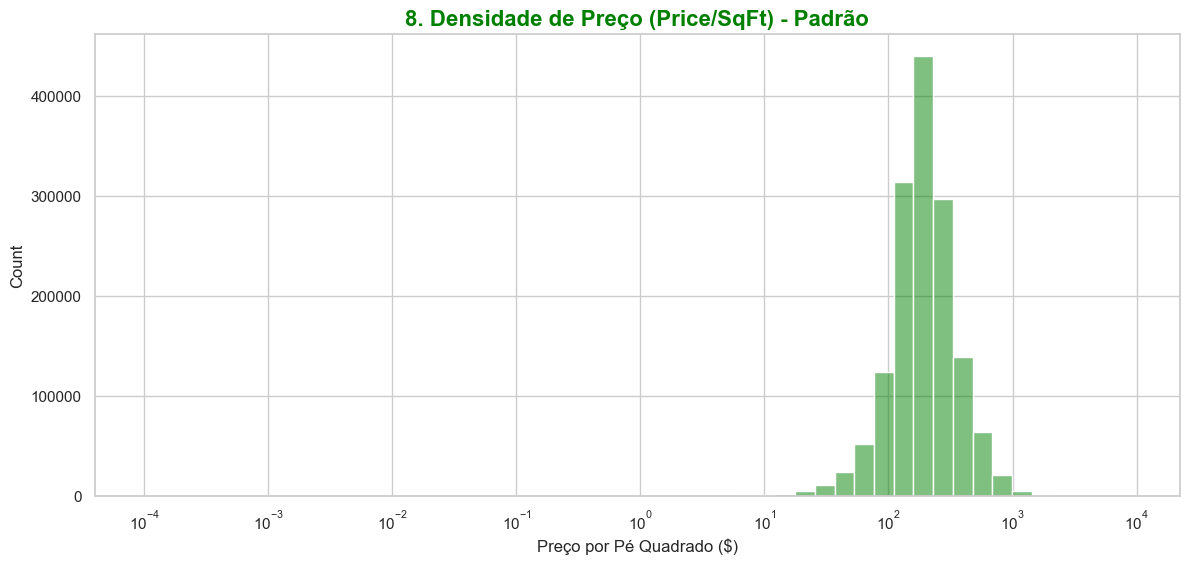

In [92]:
# --- GRÁFICO 8: Densidade de Preço (Price / SqFt) - MERCADO PADRÃO ---
plt.figure(figsize=(14, 6))

# 1. Filtra Tamanho > 10 (Evita divisão por zero)
mask_p = df_padrao['house_size'] > 10

# 2. Calcula o indicador
sqft_p = df_padrao.loc[mask_p, 'price'] / df_padrao.loc[mask_p, 'house_size']

# 3. LIMPEZA EXTRA (Resolve o RuntimeWarning)
# Substitui infinitos por NaN e depois remove todos os NaNs
sqft_p = sqft_p.replace([np.inf, -np.inf], np.nan).dropna()

# 4. Plotagem
_ = sns.histplot(sqft_p, bins=50, log_scale=True, color='green', kde=True)

plt.title('8. Densidade de Preço (Price/SqFt) - Padrão', fontweight='bold', color='green')
plt.xlabel('Preço por Pé Quadrado ($)')
plt.show()

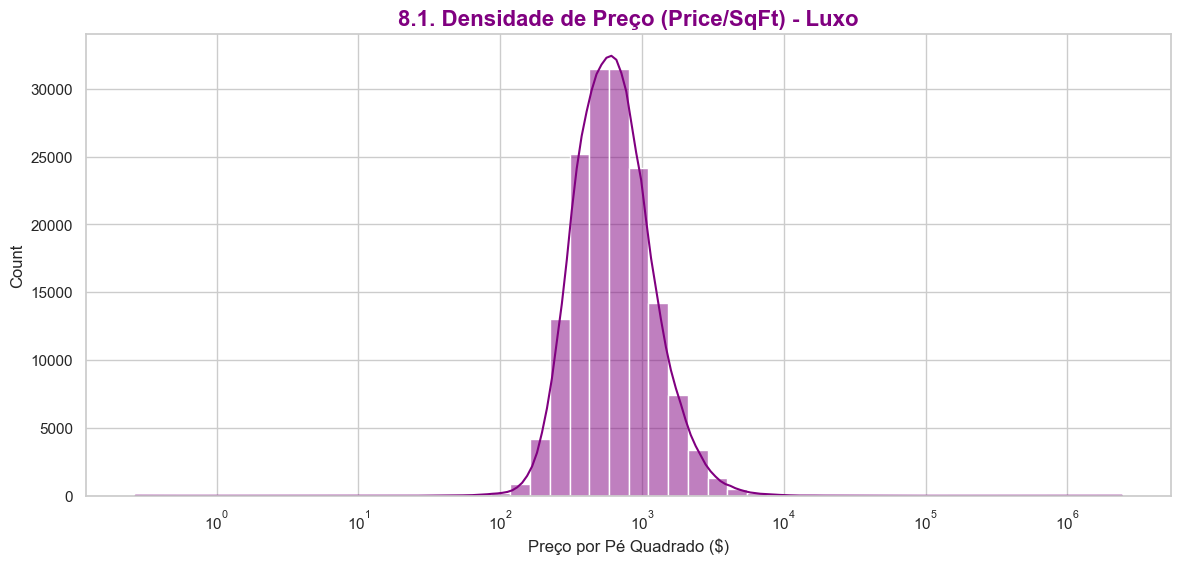

In [93]:
# --- GRÁFICO 8.1: Preço por Pé Quadrado (MERCADO DE LUXO) ---
plt.figure(figsize=(14, 6))
mask_l = df_luxo['house_size'] > 10
sqft_l = df_luxo.loc[mask_l, 'price'] / df_luxo.loc[mask_l, 'house_size']

sns.histplot(sqft_l, bins=50, log_scale=True, color='purple', kde=True)
plt.title('8.1. Densidade de Preço (Price/SqFt) - Luxo', fontweight='bold', color='purple')
plt.xlabel('Preço por Pé Quadrado ($)')
plt.show()

### 9. Corretoras por Volume de Anúncios
* **Objetivo:** Identificar se o mercado é pulverizado ou monopolizado por grandes imobiliárias.
* **O que procurar (Outliers):** Se uma única corretora (`brokered_by`) tem 50% dos dados, qualquer erro no sistema *dela* contamina metade da sua base.

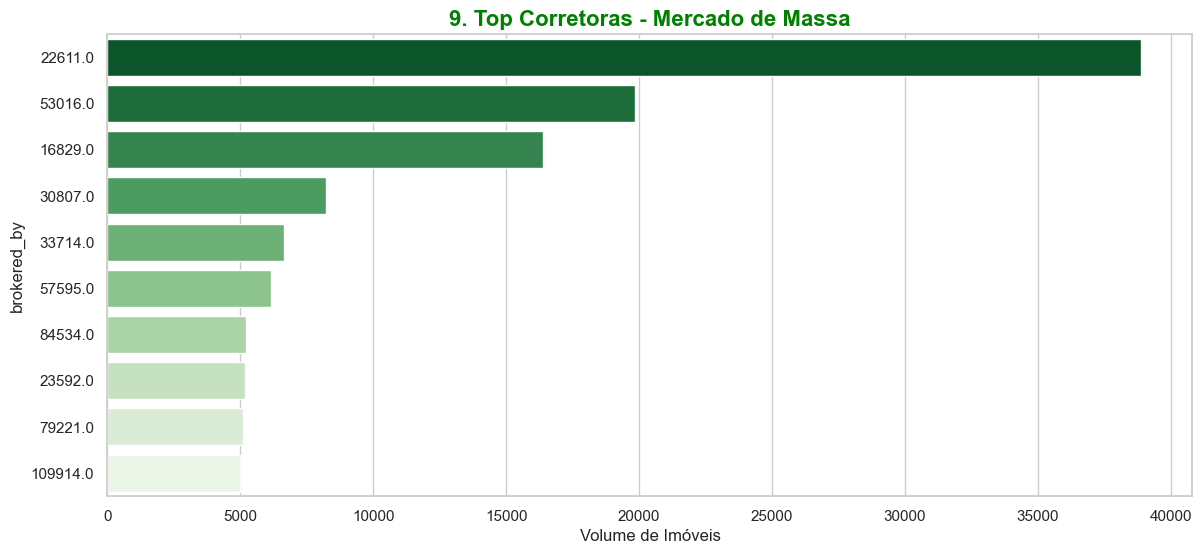

In [94]:
# --- GRÁFICO 9: Top Corretoras (MERCADO PADRÃO) ---
# Verifica se a coluna existe (Raw Data pode variar)
if 'brokered_by' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    
    # Preenche nulos com 'Desconhecido' para não dar erro
    top_brk_p = df_padrao['brokered_by'].fillna('Desconhecido').value_counts().head(10)
    
    _ = sns.barplot(
        x=top_brk_p.values, 
        y=top_brk_p.index, 
        hue=top_brk_p.index, # Define a cor
        palette='Greens_r', 
        legend=False
    )
    
    plt.title('9. Top Corretoras - Mercado de Massa', fontweight='bold', color='green')
    plt.xlabel('Volume de Imóveis')
    plt.show()

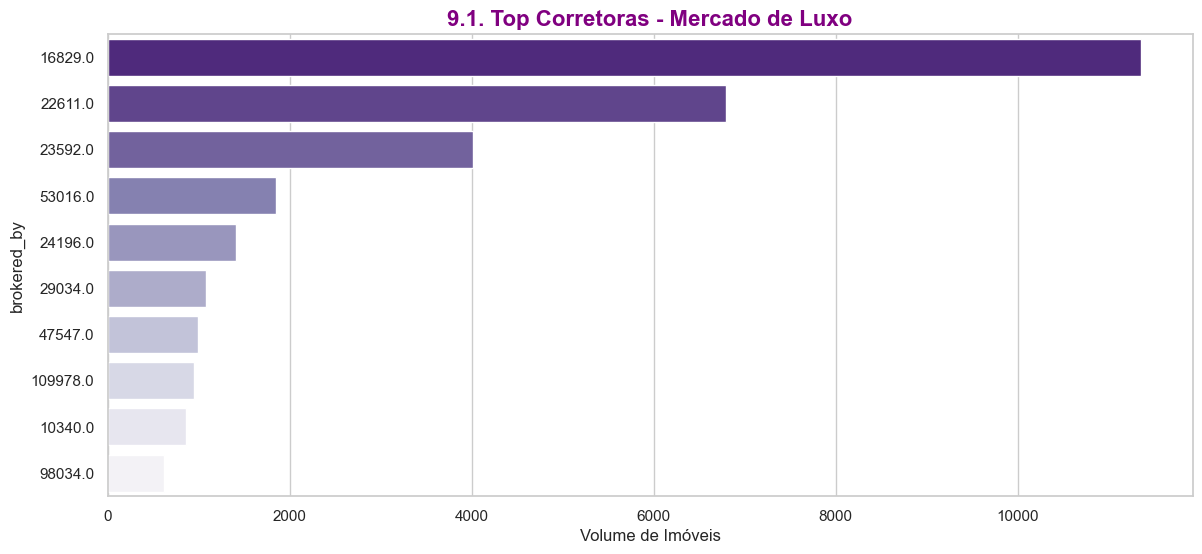

In [95]:
# --- GRÁFICO 9.1: Top Corretoras (MERCADO DE LUXO) ---
if 'brokered_by' in df_luxo.columns:
    plt.figure(figsize=(14, 6))
    
    top_brk_l = df_luxo['brokered_by'].fillna('Desconhecido').value_counts().head(10)
    
    _ = sns.barplot(
        x=top_brk_l.values, 
        y=top_brk_l.index, 
        hue=top_brk_l.index,
        palette='Purples_r', 
        legend=False
    )
    
    plt.title('9.1. Top Corretoras - Mercado de Luxo', fontweight='bold', color='purple')
    plt.xlabel('Volume de Imóveis')
    plt.show()

### 10. CEPs Mais Caros
* **Objetivo:** Zoom in nos bairros (Zip Codes). Diferente dos estados, aqui vemos a riqueza concentrada.
* **O que procurar (Outliers):** CEPs com preço mediano suspeitamente alto (possível erro de input monetário) ou baixo demais.

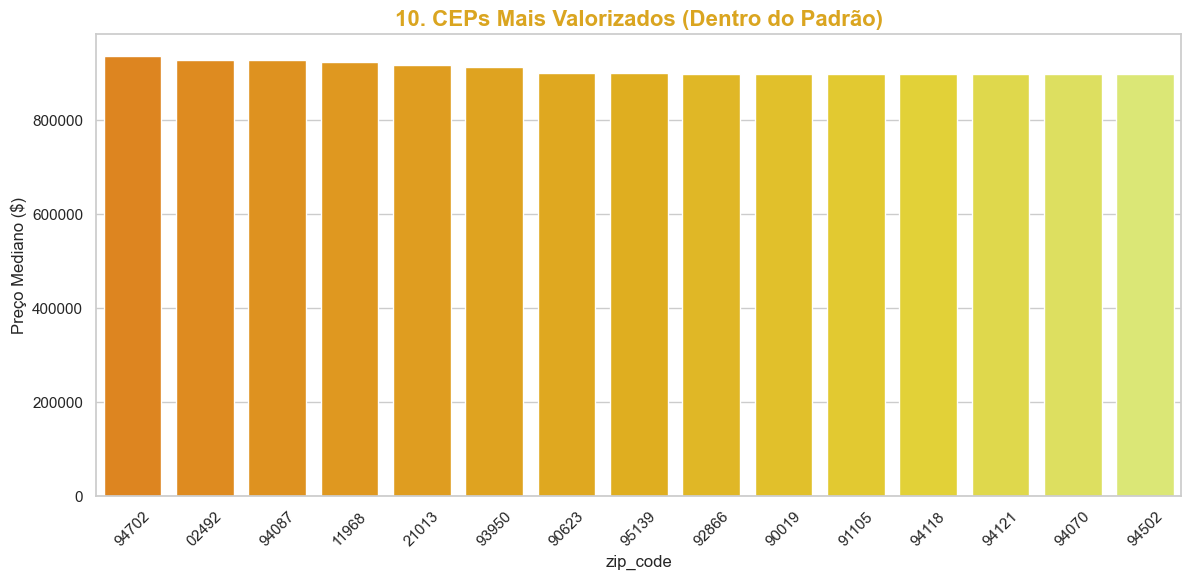

In [96]:
# --- GRÁFICO 10: CEPs Mais Caros (MERCADO PADRÃO) ---
if 'zip_code' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    
    # 1. Conta frequência
    zips_p = df_padrao['zip_code'].value_counts()
    
    # 2. Filtra CEPs com pouco volume (ruído estatístico)
    valid_zips_p = zips_p[zips_p > 20].index 
    
    # 3. Calcula mediana de preço
    wealth_p = df_padrao[df_padrao['zip_code'].isin(valid_zips_p)].groupby('zip_code')['price'].median().sort_values(ascending=False).head(15)
    
    # 4. Plotagem (com correções)
    _ = sns.barplot(
        x=wealth_p.index, 
        y=wealth_p.values, 
        hue=wealth_p.index,  # Define a cor
        palette='Wistia_r', 
        legend=False
    )
    
    plt.title('10. CEPs Mais Valorizados (Dentro do Padrão)', fontweight='bold', color='goldenrod') # Cor ajustada para combinar com o gráfico
    plt.xticks(rotation=45)
    plt.ylabel('Preço Mediano ($)')
    plt.show()

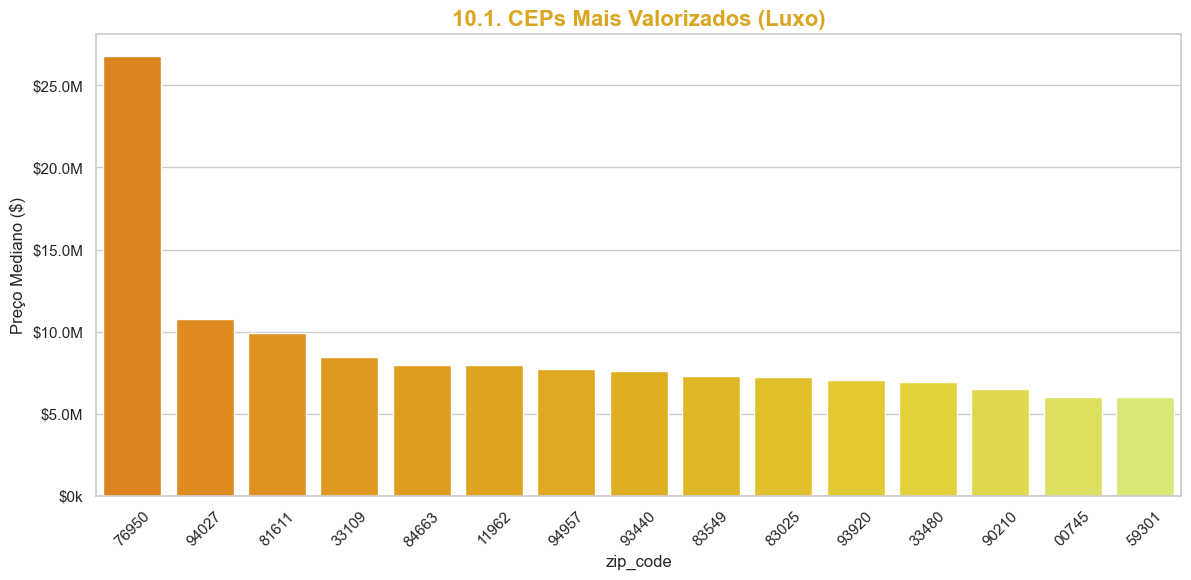

In [97]:
# --- GRÁFICO 10.1: CEPs Mais Caros (MERCADO DE LUXO) ---
if 'zip_code' in df_luxo.columns:
    plt.figure(figsize=(14, 6))
    
    zips_l = df_luxo['zip_code'].value_counts()
    valid_zips_l = zips_l[zips_l > 5].index # Filtro menor para luxo (menos dados)
    
    wealth_l = df_luxo[df_luxo['zip_code'].isin(valid_zips_l)].groupby('zip_code')['price'].median().sort_values(ascending=False).head(15)
    
    _ = sns.barplot(
        x=wealth_l.index, 
        y=wealth_l.values, 
        hue=wealth_l.index,
        palette='Wistia_r', 
        legend=False
    )
    
    plt.title('10.1. CEPs Mais Valorizados (Luxo)', fontweight='bold', color='goldenrod')
    plt.xticks(rotation=45)
    plt.ylabel('Preço Mediano ($)')
    
    # Formata eixo Y
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(format_currency))
    plt.show()

### 11. Onde os Dados Desaparecem
* **Objetivo:** Descobrir se a "sujeira" (nulos) está espalhada ou concentrada em regiões específicas.
* **O que procurar (Outliers):** Estados onde a barra de "Nulos" é gigante. Isso indica que a coleta de dados naquela região falhou drasticamente (ex: Porto Rico costuma ter muitos endereços incompletos).

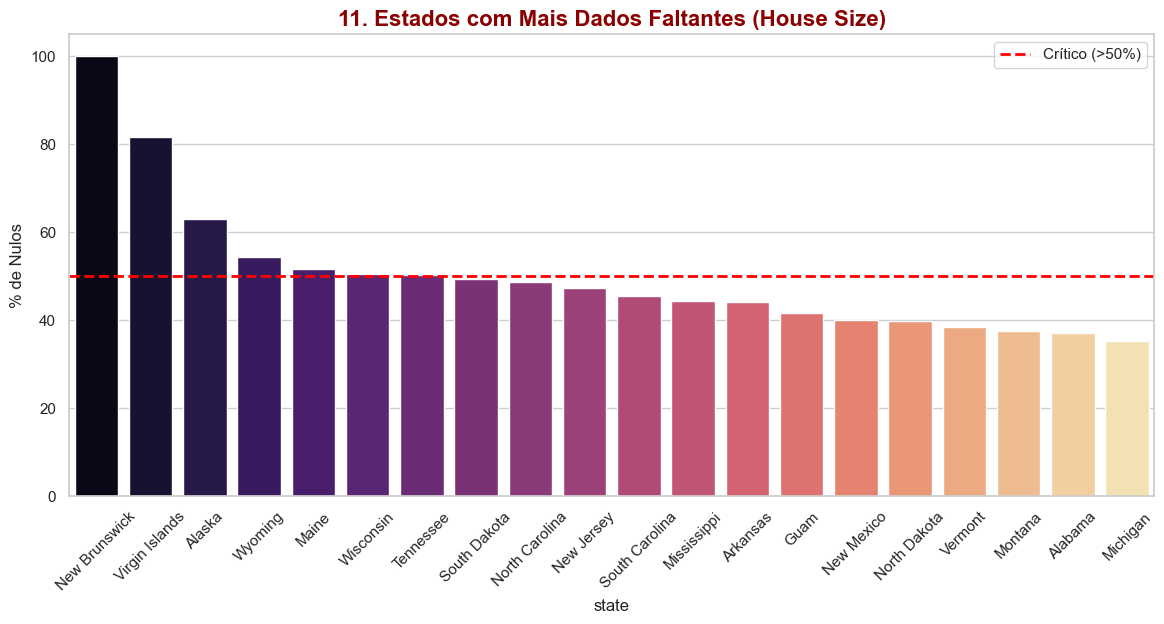

In [98]:
# --- GRÁFICO 11: Qualidade do Dado por Estado (MERCADO PADRÃO) ---
if 'state' in df_padrao.columns and 'house_size' in df_padrao.columns:
    plt.figure(figsize=(14, 6))
    
    # Calcula % de nulos em house_size por Estado
    null_rate = df_padrao.groupby('state')['house_size'].apply(lambda x: x.isnull().mean() * 100).sort_values(ascending=False).head(20)
    
    _ = sns.barplot(
        x=null_rate.index, 
        y=null_rate.values, 
        hue=null_rate.index, # Define a cor pelo estado
        palette='magma', 
        legend=False
    )
    
    plt.title('11. Estados com Mais Dados Faltantes (House Size)', fontweight='bold', color='darkred')
    plt.ylabel('% de Nulos')
    plt.xticks(rotation=45)
    
    # Linha de alerta em 50%
    plt.axhline(50, color='red', linestyle='--', linewidth=2, label='Crítico (>50%)')
    plt.legend() # Mostra a legenda da linha vermelha
    plt.show()

### 12. Quem é a Variável Mais Quebrada?
* **Objetivo:** Comparar maçãs com laranjas (Preço vs Quartos vs Tamanho). Normalizamos tudo de 0 a 1.
* **A Investigação:** A variável que tiver a caixa mais "achatada" e cheia de pontinhos pretos (outliers) é a que possui a escala mais distorcida por erros. É a "campeã de sujeira".

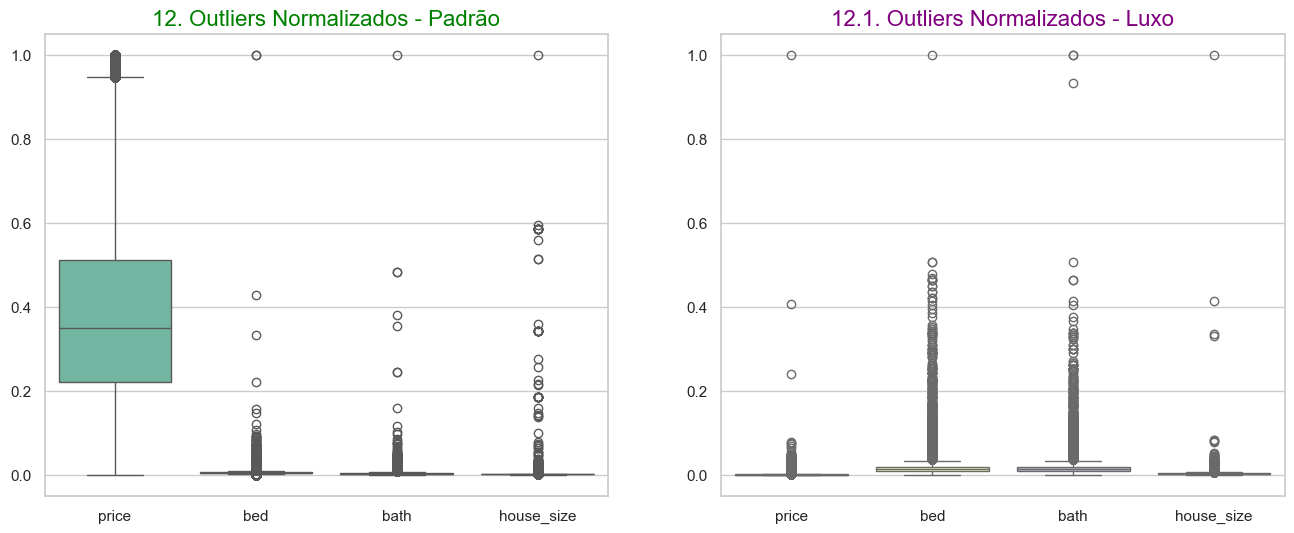

In [99]:
# --- GRÁFICO 13: Normalização (Comparação Padrão vs Luxo) ---
# Vamos plotar lado a lado no mesmo gráfico para ver a diferença de escala
df_num_p = df_padrao[['price', 'bed', 'bath', 'house_size']].dropna()
df_num_l = df_luxo[['price', 'bed', 'bath', 'house_size']].dropna()

# Normaliza (Min-Max)
df_norm_p = (df_num_p - df_num_p.min()) / (df_num_p.max() - df_num_p.min())
df_norm_l = (df_num_l - df_num_l.min()) / (df_num_l.max() - df_num_l.min())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df_norm_p, palette="Set2", ax=axes[0])
axes[0].set_title('12. Outliers Normalizados - Padrão', color='green')

sns.boxplot(data=df_norm_l, palette="Set3", ax=axes[1])
axes[1].set_title('12.1. Outliers Normalizados - Luxo', color='purple')
plt.show()

### 13. O Raio-X da Integridade (Heatmap)
* **Objetivo:** Uma visão geral de quais colunas foram "esquecidas" pelos sistemas de coleta.
* **A Investigação:** As listras amarelas mostram exatamente onde o dado falhou. Se houver um padrão (ex: blocos inteiros amarelos), significa falha sistêmica em certos períodos ou regiões.

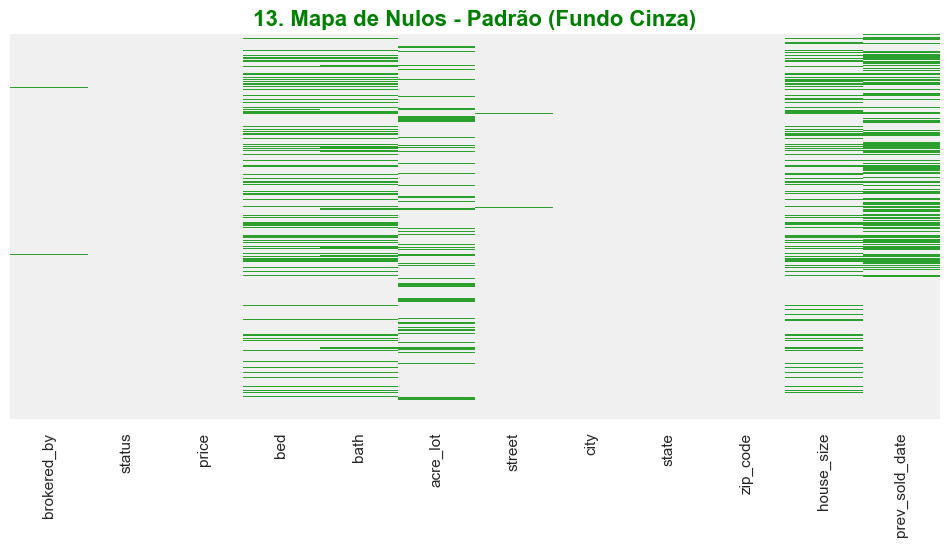

In [100]:
from matplotlib.colors import ListedColormap

# --- GRÁFICO 14: Dados Faltantes (MERCADO PADRÃO) ---
plt.figure(figsize=(12, 5))

# 1. Definindo as cores personalizadas
# A primeira cor é o FUNDO (onde o dado existe / False)
# A segunda cor é o DESTAQUE (onde é Nulo / True)
cores = ['#F0F0F0', '#2ca02c'] # Cinza claro para fundo, Verde forte para nulos
cmap_personalizado = ListedColormap(cores)

# 2. Gerando o heatmap com o novo cmap
# vmin=0 e vmax=1 garantem que o mapeamento binário funcione perfeitamente
sns.heatmap(df_padrao.isnull(), cbar=False, yticklabels=False, cmap=cmap_personalizado, vmin=0, vmax=1)

plt.title('13. Mapa de Nulos - Padrão (Fundo Cinza)', fontweight='bold', color='green')
plt.show()

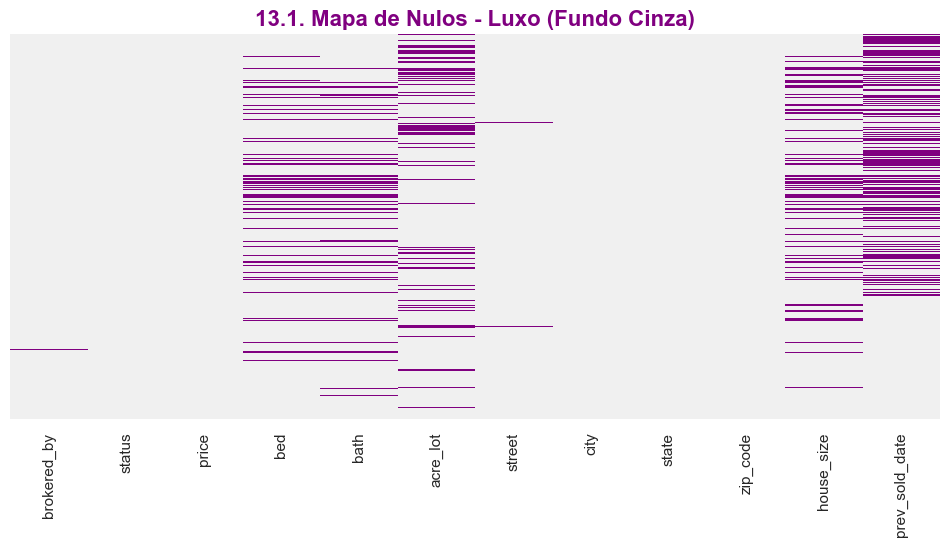

In [101]:
from matplotlib.colors import ListedColormap

# --- GRÁFICO 14.1: Dados Faltantes (MERCADO DE LUXO) ---
plt.figure(figsize=(12, 5))

# 1. Definindo as cores personalizadas para o Luxo
# Cor 1 (Fundo/False): Cinza Claro (#F0F0F0) - Indica que o dado existe
# Cor 2 (Destaque/True): Roxo ('purple') - Indica que é Nulo
cores_luxo = ['#F0F0F0', 'purple'] 
cmap_luxo = ListedColormap(cores_luxo)

# 2. Gerando o heatmap
sns.heatmap(df_luxo.isnull(), cbar=False, yticklabels=False, cmap=cmap_luxo, vmin=0, vmax=1)

plt.title('13.1. Mapa de Nulos - Luxo (Fundo Cinza)', fontweight='bold', color='purple')
plt.show()

### 14. O Resumo da Ópera (Pairplot)
* **Objetivo:** Conclusão visual. Cruzamos as 4 variáveis principais.
* **A Investigação:** Na camada Raw, esperamos ver o **caos**. Pontos espalhados sem direção, aglomerados estranhos e falta de linearidade. Isso justifica a necessidade do trabalho que faremos na camada Silver.

🕷️ Gerando Pairplot PADRÃO (Aguarde, processando estatística)...


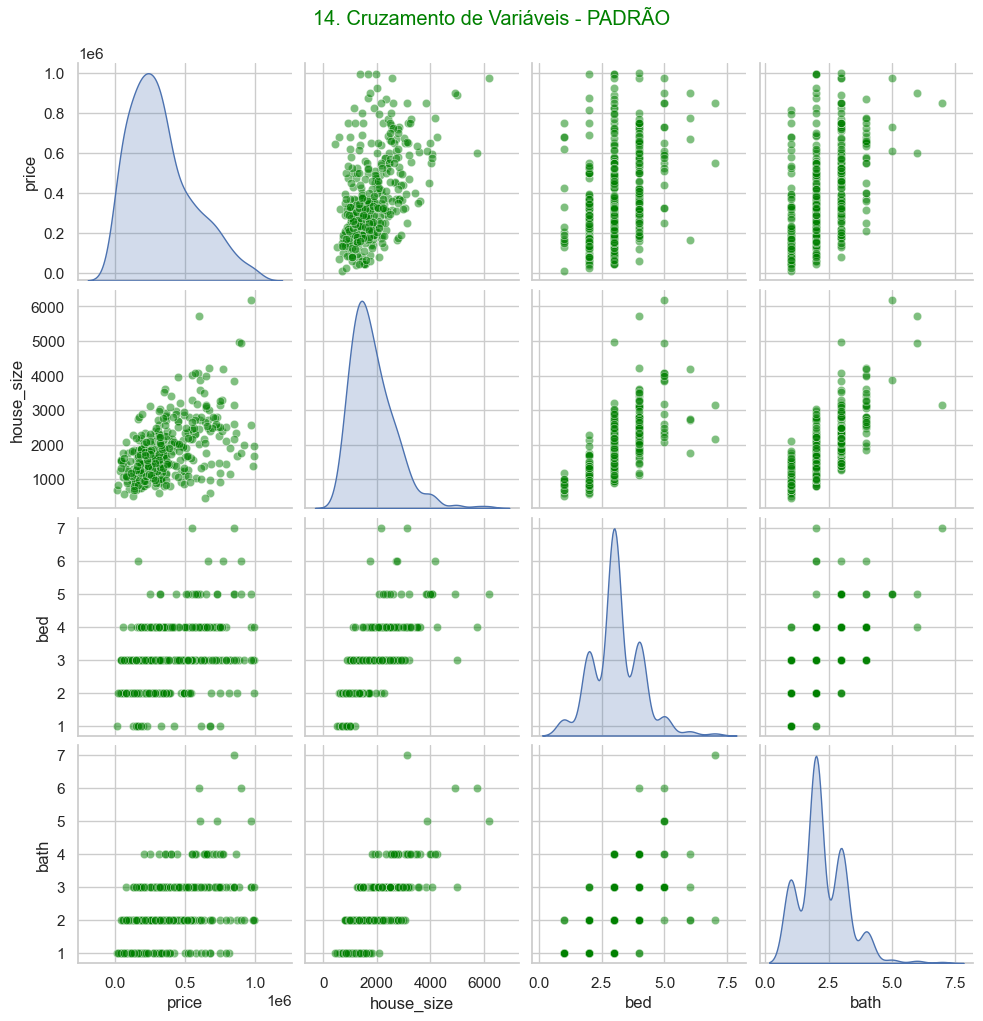

🕷️ Gerando Pairplot LUXO (Aguarde, processando estatística)...


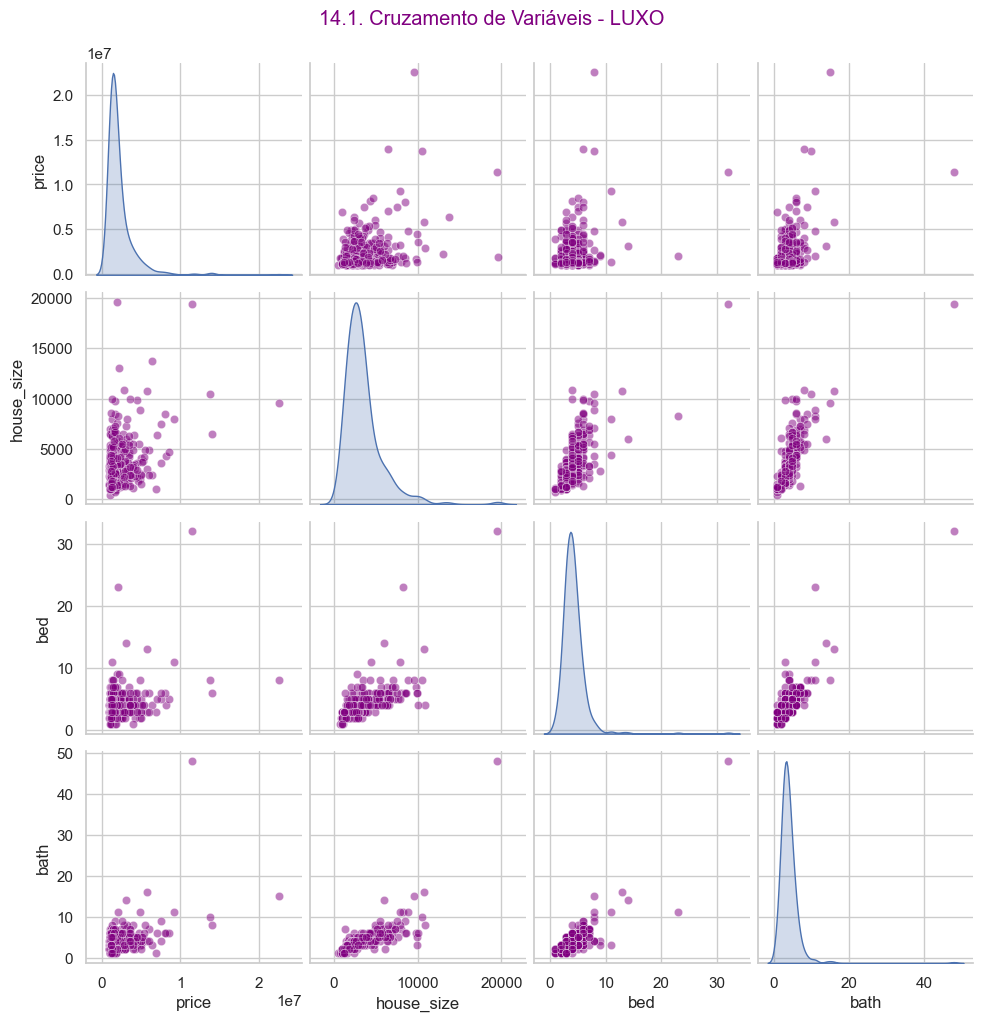

In [102]:
# --- GRÁFICO 15: Pairplot Final (A Teia de Aranha) ---
cols_spider = ['price', 'house_size', 'bed', 'bath']

print("🕷️ Gerando Pairplot PADRÃO (Aguarde, processando estatística)...")
# Amostra de 500 para não travar
g = sns.pairplot(df_padrao[cols_spider].sample(500), diag_kind='kde', plot_kws={'alpha': 0.5, 'color': 'green'})
g.fig.suptitle("14. Cruzamento de Variáveis - PADRÃO", y=1.02, color='green')
plt.show()

print("🕷️ Gerando Pairplot LUXO (Aguarde, processando estatística)...")
g = sns.pairplot(df_luxo[cols_spider].sample(500), diag_kind='kde', plot_kws={'alpha': 0.5, 'color': 'purple'})
g.fig.suptitle("14.1. Cruzamento de Variáveis - LUXO", y=1.02, color='purple')
plt.show()